This notebook for the second fairness-aware intervention was an adversarial debiasing  to prevent the model from encoding sensitive demographic information (age and breast density) into the learned representations

The basic model remains the DenseNet-121, it was modified for binary classification with three components:
1-	Feature reduction layer
2-	Main classifier
3-	Adversarial classifier.

same evaluation framework ( general performance metrics, fairness, subgroup analysis)
additional adversarial analysis

then explainability tool Grad-cam (visual and numeric)



In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# The needed libraries were imported, the details are in the baseline notebook
import os
import numpy as np
import pandas as pd
from PIL import Image
import json # to deal with JSON files
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# load and to check all the datasets then check the size
print("Loading datasets...")
train_df = pd.read_csv("/content/drive/MyDrive/VinDr_mammo.png/training_split.csv")
val_df = pd.read_csv("/content/drive/MyDrive/VinDr_mammo.png/validation_split.csv")
test_df = pd.read_csv("/content/drive/MyDrive/VinDr_mammo.png/test_samples.csv")

print(f"\nDataset sizes:")
print(f"Train: {len(train_df)} samples")
print(f"Validation: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

Loading datasets...

Dataset sizes:
Train: 12800 samples
Validation: 3200 samples
Test: 4000 samples


**To make sure all data are cleaned befor training**

In [ ]:
#data cleaning and standardaization  we already fill the missing just to double check before training
def clean_dataframe(df):
    """Handle missing values in the needed columns"""
    df_clean = df.copy()

    # Fill missing Age Group (create from Patient's Age if available)
    if 'Patient\'s Age' in df_clean.columns and 'Age Group' in df_clean.columns:
        mask = df_clean['Age Group'].isna() & df_clean['Patient\'s Age'].notna()
        def age_to_group(age):
            if pd.isna(age):
                return 'Unknown'
            age = float(age)
            if age < 20: return '<20'
            elif age < 30: return '20-29'
            elif age < 40: return '30-39'
            elif age < 50: return '40-49'
            elif age < 60: return '50-59'
            elif age < 70: return '60-69'
            elif age < 80: return '70-79'
            else: return '80+'

        df_clean.loc[mask, 'Age Group'] = df_clean.loc[mask, 'Patient\'s Age'].apply(age_to_group)

    # Fill remaining missing values
    df_clean['Age Group'] = df_clean['Age Group'].fillna('Unknown')
    df_clean['breast_density'] = df_clean['breast_density'].fillna('Unknown')

    return df_clean

train_df = clean_dataframe(train_df)
val_df = clean_dataframe(val_df)
test_df = clean_dataframe(test_df)

# **Configurations**





In [ ]:
# configaration for model hyper parameter:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224  # to match DenseNet input size
BATCH_SIZE = 32 # to improve memmory and training stability
EPOCHS = 20    # maximum training duration
LR = 1e-4   #Learning rate for Adam optimizer
PATIENCE = 10  # Increased for imbalanced data
CHECKPOINT_DIR = "/content/drive/MyDrive/IT_artefact/Adversarial_checkpoints/"  #Recovery if interruptions
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
ADVERSARIAL_CHECKPOINT = os.path.join(CHECKPOINT_DIR, "adversarial_model.pth")
RESULTS_FILE = os.path.join(CHECKPOINT_DIR, "adversarial_results.json")

In [ ]:
'''Converting BI-RADS into a binary label [0,1]for model training and
encoding age and breast density as binary sensitive attributes for adversarial interventions
then check the distribution of both class.'''

def create_binary_label(row):
    """Create binary label: low risk class 0=BI-RADS 1-2, higher risk class 1=BI-RADS 3-4-5"""
    birads = row['breast_birads']

    if isinstance(birads, str):
        import re
        match = re.search(r'(\d+)', str(birads))
        if match:
            birads_num = int(match.group(1))
        else:
            return 1
    else:
        try:
            birads_num = int(float(birads))
        except:
            return 1

    return 0 if birads_num in [1, 2] else 1

def encode_sensitive_attribute(row, attribute_type='age'):
    """Encode sensitive features for adversarial training"""
    if attribute_type == 'age':
        age_group = row['Age Group']
        # Group into young (0) vs old (1) - you can adjust this grouping
        if age_group in ['<20', '20-29', '30-39']:
            return 0  # Young
        elif age_group in ['40-49', '50-59', '60-69', '70-79', '80+']:
            return 1  # Old
        else:
            return 0  # Default
    elif attribute_type == 'density':
        density = row['breast_density']
        if density in ['DENSITY A', 'DENSITY B']:
            return 0  # Less dense
        elif density in ['DENSITY C', 'DENSITY D']:
            return 1  # More dense
        else:
            return 0
    else:
        return 0

# Apply to all dataframes
for df in [train_df, val_df, test_df]:
    df['binary_label'] = df.apply(create_binary_label, axis=1)
    df['age_attribute'] = df.apply(lambda x: encode_sensitive_attribute(x, 'age'), axis=1)
    df['density_attribute'] = df.apply(lambda x: encode_sensitive_attribute(x, 'density'), axis=1)

print("\nBinary label distribution:")
print("Train - Class 0:", sum(train_df['binary_label'] == 0),
      "Class 1:", sum(train_df['binary_label'] == 1),
      f"(Ratio: {sum(train_df['binary_label'] == 1)/sum(train_df['binary_label'] == 0):.3f})")

print("\nSensitive attribute distribution:")
print("Age (0=Young, 1=Old):", train_df['age_attribute'].value_counts().to_dict())
print("Density (0=Less dense, 1=More dense):", train_df['density_attribute'].value_counts().to_dict())


Binary label distribution:
Train - Class 0: 11586 Class 1: 1214 (Ratio: 0.105)

Sensitive attribute distribution:
Age (0=Young, 1=Old): {1: 9802, 0: 2998}
Density (0=Less dense, 1=More dense): {1: 11531, 0: 1269}


# **Model structure**

In [ ]:
'''implement integration of DenseNet-121 backbone with a gradient reversal-based adversary network,
 enabling the main classifier to predict class 1 while discouraging encoding of sensitive attributes for fairness-aware learning.'''
# Gradient Reversal Function
class GradientReversal(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_, None

class AdversarialNetwork(nn.Module):
    """Adversary network to predict sensitive attribute"""
    def __init__(self, input_dim=512, hidden_dim=256, num_classes=2):
        super(AdversarialNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        return self.network(x)

class AdversarialDenseNet(nn.Module):
    """Main model with adversarial debiasing"""
    def __init__(self, num_classes=2, adversary_type='age'):
        super(AdversarialDenseNet, self).__init__()
        self.adversary_type = adversary_type

        # Main classifier
        self.backbone = models.densenet121(pretrained=True)
        num_features = self.backbone.classifier.in_features  # 1024

        # Replace the classifier
        self.backbone.classifier = nn.Identity()  # Remove original classifier

        # Feature reducer (1024 -> 512)(based on the number of channel in DenseNET121)
        self.feature_reducer = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        # Main classifier (512 -> 256 -> num_classes)
        self.main_classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        # Adversarial classifier
        self.adversary = AdversarialNetwork(512, hidden_dim=256, num_classes=2)

    def get_shared_features(self, x):
        """Extract shared features from backbone"""
        features = self.backbone(x)  # Shape: [batch_size, 1024]
        reduced_features = self.feature_reducer(features)  # Shape: [batch_size, 512]
        return reduced_features

    def forward(self, x, return_features=False, lambda_val=1.0):
        # Get shared features
        shared_features = self.get_shared_features(x)  # [batch_size, 512]

        # Main task prediction
        main_output = self.main_classifier(shared_features)

        # Adversarial prediction with gradient reversal
        reversed_features = GradientReversal.apply(shared_features, lambda_val)
        adversary_output = self.adversary(reversed_features)

        if return_features:
            return main_output, adversary_output, shared_features
        return main_output, adversary_output

In [ ]:
'''class loads preprocessed mammography images along with the binary target label and sensitive attributes (age and breast density),
then, data augmentation, including flipping, rotation, and color jitter,
is done to the training set to support model generalization, while validation images are only resized and normalized'''

# Custom Dataset for Mammography Images with Sensitive Attributes

class MammoDatasetWithAttributes(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        img_path = row['preprocessed_path']
        try:
            img = Image.open(img_path).convert('RGB')
        except:
            img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')

        # Apply transforms
        if self.transform:
            img = self.transform(img)

        # Get labels
        main_label = torch.tensor(row['binary_label'], dtype=torch.long)
        age_attr = torch.tensor(row['age_attribute'], dtype=torch.long)
        density_attr = torch.tensor(row['density_attribute'], dtype=torch.long)

        return img, main_label, age_attr, density_attr

# transform with augmentation

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

In [ ]:
'''The training, validation, and test datasets were loaded using the  MammoDatasetWithAttributes,
including the binary outcome and sensitive attributes,
and dataLoaders was used to handle batching and shuffling, with only the training set shuffled.'''

train_dataset = MammoDatasetWithAttributes(train_df, transform=train_transform)
val_dataset = MammoDatasetWithAttributes(val_df, transform=val_transform)
test_dataset = MammoDatasetWithAttributes(test_df, transform=val_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

In [ ]:
'''nitializes an adversarial DenseNet model with separate optimizers and schedulers for the main classifier and adversary,
sets loss functions, and prints device placement and total trainable parameters for training setup
 and fairness-aware learning'''

print("\nInitializing adversarial intervention model...")
model = AdversarialDenseNet(num_classes=2, adversary_type='age').to(DEVICE)

# Optimizers
main_optimizer = optim.Adam([
    {'params': model.backbone.parameters(), 'lr': LR * 0.1},  # Lower lr for pretrained
    {'params': model.feature_reducer.parameters()},
    {'params': model.main_classifier.parameters()}
], lr=LR, weight_decay=1e-4)

adversary_optimizer = optim.Adam(model.adversary.parameters(), lr=LR, weight_decay=1e-4)

# Loss functions
main_criterion = nn.CrossEntropyLoss()
adversary_criterion = nn.CrossEntropyLoss()

# Schedulers
main_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    main_optimizer, mode='min', patience=3, factor=0.5
)

adversary_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    adversary_optimizer, mode='min', patience=3, factor=0.5
)

print(f"Model initialized on {DEVICE}")
print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Initializing adversarial intervention model...
Model initialized on cuda
Total trainable parameters: 7,776,004


In [ ]:
'''These functions implement adversarial debiasing by jointly training a predictive model and
a sensitive-attribute adversary,
encouraging invariant feature learning and preserving diagnostic performance
λ regulates the influence of the adversarial objective,
enabling controlled removal of sensitive attribute information while maintaining diagnostic performanc'''

def adversarial_train_epoch(model, loader, main_optimizer, adversary_optimizer,
                           main_criterion, adversary_criterion, device,
                           lambda_val=1.0, adversary_type='age'):
    """Training with adversarial debiasing"""
    model.train()
    total_main_loss = 0
    total_adv_loss = 0
    correct_main = 0
    correct_adv = 0
    total_samples = 0

    pbar = tqdm(loader, desc="Adversarial Training")
    for batch_idx, (images, main_labels, age_attrs, density_attrs) in enumerate(pbar):
        images = images.to(device)
        main_labels = main_labels.to(device)

        # Select adversary target based on type
        if adversary_type == 'age':
            adv_labels = age_attrs.to(device)
        elif adversary_type == 'density':
            adv_labels = density_attrs.to(device)
        else:
            adv_labels = age_attrs.to(device)

        #  STEP 1: Train adversary
        adversary_optimizer.zero_grad()

        # Forward with detached features (so adversary doesn't affect shared layers)
        with torch.no_grad():
            shared_features = model.get_shared_features(images)

        # Train adversary normally
        adv_outputs = model.adversary(shared_features)
        adv_loss = adversary_criterion(adv_outputs, adv_labels)
        adv_loss.backward()
        adversary_optimizer.step()

        # STEP 2: Train main model with adversarial debiasing
        main_optimizer.zero_grad()

        # Forward pass with gradient reversal
        main_outputs, adv_outputs = model(images, lambda_val=lambda_val)

        # Main task loss
        main_loss = main_criterion(main_outputs, main_labels)

        # Adversary loss (we want to minimize the adversary's ability)
        adv_loss_debias = adversary_criterion(adv_outputs, adv_labels)

        # Combined loss: minimize main loss, maximize adversary loss (negative sign)
        total_loss = main_loss - 0.1 * adv_loss_debias  # 0.1 is adversarial weight

        # Backward pass
        total_loss.backward()
        main_optimizer.step()

        # Track losses
        total_main_loss += main_loss.item()
        total_adv_loss += adv_loss.item()

        # Calculate accuracies
        _, main_preds = main_outputs.max(1)
        _, adv_preds = adv_outputs.max(1)

        correct_main += main_preds.eq(main_labels).sum().item()
        correct_adv += adv_preds.eq(adv_labels).sum().item()
        total_samples += main_labels.size(0)

        # Update progress bar
        pbar.set_postfix({
            'Main Loss': f'{main_loss.item():.4f}',
            'Adv Loss': f'{adv_loss.item():.4f}',
            'Main Acc': f'{100.*correct_main/total_samples:.2f}%',
            'Adv Acc': f'{100.*correct_adv/total_samples:.2f}%'
        })

    avg_main_loss = total_main_loss / len(loader)
    avg_adv_loss = total_adv_loss / len(loader)
    main_acc = 100. * correct_main / total_samples
    adv_acc = 100. * correct_adv / total_samples

    return avg_main_loss, avg_adv_loss, main_acc, adv_acc
#validation function

def adversarial_validate(model, loader, main_criterion, device, adversary_type='age'):
    """Validation for adversarial model"""
    model.eval()
    total_main_loss = 0
    correct_main = 0
    total_samples = 0
    all_main_probs = []
    all_main_labels = []

    with torch.no_grad():
        for images, main_labels, age_attrs, density_attrs in tqdm(loader, desc="Validation"):
            images = images.to(device)
            main_labels = main_labels.to(device)

            # Forward pass (no adversarial during validation)
            main_outputs, _ = model(images, lambda_val=0.0)  # No gradient reversal

            # Main task loss
            main_loss = main_criterion(main_outputs, main_labels)
            total_main_loss += main_loss.item()

            # Get predictions and probabilities
            main_probs = torch.softmax(main_outputs, dim=1)[:, 1]
            _, main_preds = main_outputs.max(1)

            correct_main += main_preds.eq(main_labels).sum().item()
            total_samples += main_labels.size(0)

            all_main_probs.extend(main_probs.cpu().numpy())
            all_main_labels.extend(main_labels.cpu().numpy())

    avg_main_loss = total_main_loss / len(loader)
    main_acc = 100. * correct_main / total_samples

    # Calculate AUC
    if len(set(all_main_labels)) > 1:
        auc = roc_auc_score(all_main_labels, all_main_probs)
    else:
        auc = 0.5

    return avg_main_loss, main_acc, auc, all_main_probs, all_main_labels


In [ ]:
#training loop with adversarial intervention

print("\n" + "="*50)
print("starting the adversarial intervention training")
print("="*50)

best_val_auc = 0
patience_counter = 0
train_history = {
    'main_loss': [], 'adv_loss': [], 'main_acc': [], 'adv_acc': [],
    'val_loss': [], 'val_acc': [], 'val_auc': []
}

# Lambda scheduling for adversarial strength
def get_lambda_schedule(epoch, total_epochs):
    """Schedule lambda value for gradient reversal"""
    # Start with low lambda, increase gradually
    base_lambda = 0.1
    max_lambda = 1.0
    if epoch < total_epochs // 3:
        return base_lambda
    elif epoch < 2 * total_epochs // 3:
        return (max_lambda + base_lambda) / 2
    else:
        return max_lambda

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # Get current lambda value
    current_lambda = get_lambda_schedule(epoch, EPOCHS)
    print(f"Adversarial strength (lambda): {current_lambda:.3f}")

    # Training with adversarial debiasing
    avg_main_loss, avg_adv_loss, main_acc, adv_acc = adversarial_train_epoch(
        model, train_loader, main_optimizer, adversary_optimizer,
        main_criterion, adversary_criterion, DEVICE,
        lambda_val=current_lambda, adversary_type='age'
    )

    # Validation
    val_loss, val_acc, val_auc, val_probs, val_labels = adversarial_validate(
        model, val_loader, main_criterion, DEVICE, adversary_type='age'
    )

    # Update schedulers
    main_scheduler.step(val_loss)
    adversary_scheduler.step(avg_adv_loss)

    # Save history
    train_history['main_loss'].append(avg_main_loss)
    train_history['adv_loss'].append(avg_adv_loss)
    train_history['main_acc'].append(main_acc)
    train_history['adv_acc'].append(adv_acc)
    train_history['val_loss'].append(val_loss)
    train_history['val_acc'].append(val_acc)
    train_history['val_auc'].append(val_auc)

    print(f"Train Main Loss: {avg_main_loss:.4f}, Train Main Acc: {main_acc:.2f}%")
    print(f"Train Adv Loss: {avg_adv_loss:.4f}, Train Adv Acc: {adv_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val AUC: {val_auc:.4f}")

    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'main_optimizer_state_dict': main_optimizer.state_dict(),
            'adversary_optimizer_state_dict': adversary_optimizer.state_dict(),
            'val_auc': val_auc,
            'train_history': train_history,
            'lambda_val': current_lambda
        }, ADVERSARIAL_CHECKPOINT)
        print(f"✓ Saved best model with AUC: {val_auc:.4f}")
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epochs")

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print(f"\nBest validation AUC: {best_val_auc:.4f}")


starting the adversarial intervention training

Epoch 1/20
Adversarial strength (lambda): 0.100


Validation: 100%|██████████| 100/100 [18:33<00:00, 11.13s/it]


Train Main Loss: 0.3266, Train Main Acc: 89.95%
Train Adv Loss: 0.5475, Train Adv Acc: 76.25%
Val Loss: 0.3152, Val Acc: 90.00%, Val AUC: 0.6385
✓ Saved best model with AUC: 0.6385

Epoch 2/20
Adversarial strength (lambda): 0.100


Validation: 100%|██████████| 100/100 [00:07<00:00, 12.77it/s]


Train Main Loss: 0.3090, Train Main Acc: 90.52%
Train Adv Loss: 0.5264, Train Adv Acc: 76.62%
Val Loss: 0.3109, Val Acc: 90.00%, Val AUC: 0.6673
✓ Saved best model with AUC: 0.6673

Epoch 3/20
Adversarial strength (lambda): 0.100


Validation: 100%|██████████| 100/100 [00:07<00:00, 12.81it/s]


Train Main Loss: 0.3009, Train Main Acc: 90.52%
Train Adv Loss: 0.5146, Train Adv Acc: 76.66%
Val Loss: 0.3025, Val Acc: 90.00%, Val AUC: 0.6957
✓ Saved best model with AUC: 0.6957

Epoch 4/20
Adversarial strength (lambda): 0.100


Validation: 100%|██████████| 100/100 [00:07<00:00, 13.00it/s]


Train Main Loss: 0.2946, Train Main Acc: 90.53%
Train Adv Loss: 0.5114, Train Adv Acc: 76.61%
Val Loss: 0.3012, Val Acc: 90.19%, Val AUC: 0.7179
✓ Saved best model with AUC: 0.7179

Epoch 5/20
Adversarial strength (lambda): 0.100


Validation: 100%|██████████| 100/100 [00:07<00:00, 13.01it/s]


Train Main Loss: 0.2810, Train Main Acc: 90.74%
Train Adv Loss: 0.5056, Train Adv Acc: 76.65%
Val Loss: 0.2936, Val Acc: 90.56%, Val AUC: 0.7310
✓ Saved best model with AUC: 0.7310

Epoch 6/20
Adversarial strength (lambda): 0.100


Validation: 100%|██████████| 100/100 [00:07<00:00, 12.66it/s]


Train Main Loss: 0.2683, Train Main Acc: 91.14%
Train Adv Loss: 0.5035, Train Adv Acc: 76.90%
Val Loss: 0.2935, Val Acc: 90.88%, Val AUC: 0.7198
No improvement for 1 epochs

Epoch 7/20
Adversarial strength (lambda): 0.550


Validation: 100%|██████████| 100/100 [00:07<00:00, 12.96it/s]


Train Main Loss: 0.2615, Train Main Acc: 91.45%
Train Adv Loss: 0.4996, Train Adv Acc: 77.00%
Val Loss: 0.2911, Val Acc: 90.88%, Val AUC: 0.7196
No improvement for 2 epochs

Epoch 8/20
Adversarial strength (lambda): 0.550


Validation: 100%|██████████| 100/100 [00:07<00:00, 13.09it/s]


Train Main Loss: 0.2514, Train Main Acc: 91.48%
Train Adv Loss: 0.4936, Train Adv Acc: 77.23%
Val Loss: 0.2919, Val Acc: 90.62%, Val AUC: 0.7186
No improvement for 3 epochs

Epoch 9/20
Adversarial strength (lambda): 0.550


Validation: 100%|██████████| 100/100 [00:07<00:00, 12.92it/s]


Train Main Loss: 0.2391, Train Main Acc: 91.84%
Train Adv Loss: 0.4865, Train Adv Acc: 77.05%
Val Loss: 0.2930, Val Acc: 90.84%, Val AUC: 0.7112
No improvement for 4 epochs

Epoch 10/20
Adversarial strength (lambda): 0.550


Validation: 100%|██████████| 100/100 [00:07<00:00, 13.29it/s]


Train Main Loss: 0.2306, Train Main Acc: 92.02%
Train Adv Loss: 0.4858, Train Adv Acc: 77.30%
Val Loss: 0.2928, Val Acc: 90.44%, Val AUC: 0.7204
No improvement for 5 epochs

Epoch 11/20
Adversarial strength (lambda): 0.550


Validation: 100%|██████████| 100/100 [00:07<00:00, 12.69it/s]


Train Main Loss: 0.2250, Train Main Acc: 92.22%
Train Adv Loss: 0.4804, Train Adv Acc: 77.62%
Val Loss: 0.3028, Val Acc: 90.91%, Val AUC: 0.7114
No improvement for 6 epochs

Epoch 12/20
Adversarial strength (lambda): 0.550


Validation: 100%|██████████| 100/100 [00:07<00:00, 13.14it/s]


Train Main Loss: 0.2062, Train Main Acc: 92.70%
Train Adv Loss: 0.4778, Train Adv Acc: 77.59%
Val Loss: 0.3107, Val Acc: 90.91%, Val AUC: 0.7109
No improvement for 7 epochs

Epoch 13/20
Adversarial strength (lambda): 0.550


Validation: 100%|██████████| 100/100 [00:07<00:00, 13.58it/s]


Train Main Loss: 0.1956, Train Main Acc: 92.89%
Train Adv Loss: 0.4771, Train Adv Acc: 77.50%
Val Loss: 0.3299, Val Acc: 90.88%, Val AUC: 0.7010
No improvement for 8 epochs

Epoch 14/20
Adversarial strength (lambda): 1.000


Validation: 100%|██████████| 100/100 [00:07<00:00, 12.94it/s]


Train Main Loss: 0.1919, Train Main Acc: 93.16%
Train Adv Loss: 0.4747, Train Adv Acc: 77.59%
Val Loss: 0.3385, Val Acc: 90.34%, Val AUC: 0.7020
No improvement for 9 epochs

Epoch 15/20
Adversarial strength (lambda): 1.000


Validation: 100%|██████████| 100/100 [00:07<00:00, 13.22it/s]

Train Main Loss: 0.1811, Train Main Acc: 93.40%
Train Adv Loss: 0.4700, Train Adv Acc: 77.94%
Val Loss: 0.3497, Val Acc: 90.16%, Val AUC: 0.6960
No improvement for 10 epochs

Early stopping triggered at epoch 15

Best validation AUC: 0.7310


In [ ]:
# load best model

print("\nLoading best adversarial model for evaluation...")


checkpoint = torch.load(ADVERSARIAL_CHECKPOINT, map_location=DEVICE, weights_only=False)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f" Loaded model from epoch {checkpoint['epoch']} with AUC: {checkpoint['val_auc']:.4f}")


Loading best adversarial model for evaluation...
✓ Loaded model from epoch 4 with AUC: 0.7310


# **Evaluation of general model performance**

In [ ]:
# test data evaluation
print("\n" + "="*50)
print("test dataset evaluation after adversarial intervention")
print("="*50)

test_loss, test_acc, test_auc, test_probs, test_labels = adversarial_validate(
    model, test_loader, main_criterion, DEVICE, adversary_type='age'
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test AUC: {test_auc:.4f}")

# Confusion matrix
test_preds = [1 if p > 0.5 else 0 for p in test_probs]
cm = confusion_matrix(test_labels, test_preds)
print("\nConfusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['BI-RADS 1-2', 'BI-RADS 3-5']))

# sensitivity and specificity

tp = sum((p == 1 and y == 1) for p, y in zip(test_preds, test_labels))
tn = sum((p == 0 and y == 0) for p, y in zip(test_preds, test_labels))
fp = sum((p == 1 and y == 0) for p, y in zip(test_preds, test_labels))
fn = sum((p == 0 and y == 1) for p, y in zip(test_preds, test_labels))

sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

print(f"Sensitivity: {sensitivity:.3f}" if not np.isnan(sensitivity) else "Sensitivity: N/A")
print(f"Specificity: {specificity:.3f}" if not np.isnan(specificity) else "Specificity: N/A")


test dataset evaluation after adversarial intervention


Validation: 100%|██████████| 125/125 [00:09<00:00, 13.51it/s]

Test Loss: 0.2917
Test Accuracy: 91.03%
Test AUC: 0.7026

Confusion Matrix:
[[3611    5]
 [ 354   30]]

Classification Report:
              precision    recall  f1-score   support

 BI-RADS 1-2       0.91      1.00      0.95      3616
 BI-RADS 3-5       0.86      0.08      0.14       384

    accuracy                           0.91      4000
   macro avg       0.88      0.54      0.55      4000
weighted avg       0.91      0.91      0.87      4000

Sensitivity: 0.078
Specificity: 0.999


# **Subgroup analysis**

In [ ]:
'''subgroup analysis with adversarial intervention evaluate the adversarially
trained model’s performance across different subgroups (age groups and breast density categories) '''

print("\n" + "="*50)
print("subgroup analysis after adversarial training")
print("="*50)

def evaluate_subgroup_adversarial(df, subgroup_col, model, transform, device):
    """Evaluate adversarial model on subgroups including sensitivity & specificity"""
    results = {}

    for group in df[subgroup_col].unique():
        subgroup_df = df[df[subgroup_col] == group]

        if len(subgroup_df) < 5:
            print(f"   Warning: {group} has only {len(subgroup_df)} samples")
            continue

        subgroup_dataset = MammoDatasetWithAttributes(subgroup_df, transform=val_transform)
        subgroup_loader = DataLoader(subgroup_dataset, batch_size=BATCH_SIZE, shuffle=False)

        model.eval()
        all_probs = []
        all_labels = []

        with torch.no_grad():
            for images, main_labels, _, _ in subgroup_loader:
                images = images.to(device)
                main_outputs, _ = model(images, lambda_val=0.0)
                probs = torch.softmax(main_outputs, dim=1)[:, 1]
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(main_labels.numpy())

        preds = [1 if p > 0.5 else 0 for p in all_probs]

        # Metrics
        acc = accuracy_score(all_labels, preds) if len(all_labels) > 0 else np.nan
        try:
            auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else np.nan
        except:
            auc = np.nan

        # Sensitivity and Specificity
        tp = sum((p == 1 and y == 1) for p, y in zip(preds, all_labels))
        tn = sum((p == 0 and y == 0) for p, y in zip(preds, all_labels))
        fp = sum((p == 1 and y == 0) for p, y in zip(preds, all_labels))
        fn = sum((p == 0 and y == 1) for p, y in zip(preds, all_labels))

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

        results[group] = {
            'auc': auc,
            'accuracy': acc,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'n_samples': len(all_labels),
            'n_positive': int(sum(all_labels)),
            'n_negative': len(all_labels) - int(sum(all_labels))
        }

    return results

# Evaluate by Age Group
age_results = evaluate_subgroup_adversarial(test_df, 'Age Group', model, val_transform, DEVICE)

def sort_age_groups(age_groups):
    def extract_min_age(age_str):
        if age_str == '<20': return 0
        elif age_str == '20-29': return 20
        elif age_str == '30-39': return 30
        elif age_str == '40-49': return 40
        elif age_str == '50-59': return 50
        elif age_str == '60-69': return 60
        elif age_str == '70-79': return 70
        else: return float('inf')
    return sorted(age_groups, key=extract_min_age)

print("\nPERFORMANCE BY AGE GROUP")
for age in sort_age_groups(age_results.keys()):
    metrics = age_results[age]
    auc_str = f"{metrics['auc']:.3f}" if not np.isnan(metrics['auc']) else "N/A"
    acc_str = f"{metrics['accuracy']:.3f}" if not np.isnan(metrics['accuracy']) else "N/A"
    sens_str = f"{metrics['sensitivity']:.3f}" if not np.isnan(metrics['sensitivity']) else "N/A"
    spec_str = f"{metrics['specificity']:.3f}" if not np.isnan(metrics['specificity']) else "N/A"
    print(f"  {age}: AUC={auc_str}, Acc={acc_str}, Sens={sens_str}, Spec={spec_str}, N={metrics['n_samples']}")

# Evaluate by Breast Density
density_results = evaluate_subgroup_adversarial(test_df, 'breast_density', model, val_transform, DEVICE)
density_order = ['DENSITY A', 'DENSITY B', 'DENSITY C', 'DENSITY D']

print("\nPERFORMANCE BY BREAST DENSITY")
for density in density_order:
    if density in density_results:
        metrics = density_results[density]
        auc_str = f"{metrics['auc']:.3f}" if not np.isnan(metrics['auc']) else "N/A"
        acc_str = f"{metrics['accuracy']:.3f}" if not np.isnan(metrics['accuracy']) else "N/A"
        sens_str = f"{metrics['sensitivity']:.3f}" if not np.isnan(metrics['sensitivity']) else "N/A"
        spec_str = f"{metrics['specificity']:.3f}" if not np.isnan(metrics['specificity']) else "N/A"
        print(f"  {density}: AUC={auc_str}, Acc={acc_str}, Sens={sens_str}, Spec={spec_str}, N={metrics['n_samples']}")



subgroup analysis after adversarial training

PERFORMANCE BY AGE GROUP
  20-29: AUC=0.476, Acc=0.949, Sens=0.000, Spec=0.992, N=136
  30-39: AUC=0.669, Acc=0.912, Sens=0.014, Spec=0.999, N=816
  40-49: AUC=0.708, Acc=0.913, Sens=0.090, Spec=1.000, N=1968
  50-59: AUC=0.703, Acc=0.913, Sens=0.083, Spec=0.997, N=784
  60-69: AUC=0.780, Acc=0.881, Sens=0.100, Spec=0.995, N=236
  70-79: AUC=0.753, Acc=0.768, Sens=0.188, Spec=1.000, N=56

PERFORMANCE BY BREAST DENSITY
  DENSITY A: AUC=N/A, Acc=1.000, Sens=N/A, Spec=1.000, N=20
  DENSITY B: AUC=0.853, Acc=0.924, Sens=0.194, Spec=1.000, N=380
  DENSITY C: AUC=0.697, Acc=0.905, Sens=0.075, Spec=0.998, N=3060
  DENSITY D: AUC=0.596, Acc=0.926, Sens=0.000, Spec=1.000, N=540


# **Fairness metrics**

In [ ]:
'''evaluate and quantify fairness in the adversarially trained model by DP, EO,DIR
 across age and breast density subgroups,
'''


print("\n" + "="*50)
print("Fairness metrics with adversarial debiasing ")
print("="*50)

def calculate_fairness_metrics(df, subgroup_col, model, transform, device, threshold=0.5):
    """Calculate fairness metrics for adversarial model"""
    positive_rates = {}
    tprs = {}

    for group in df[subgroup_col].unique():
        subgroup_df = df[df[subgroup_col] == group]

        if len(subgroup_df) < 10:
            print(f"  Note: {group} has only {len(subgroup_df)} samples")
            continue

        # For all predictions (Demographic Parity)
        all_dataset = MammoDatasetWithAttributes(subgroup_df, transform=val_transform)
        all_loader = DataLoader(all_dataset, batch_size=BATCH_SIZE, shuffle=False)

        # For positive cases only (Equal Opportunity)
        positive_df = subgroup_df[subgroup_df['binary_label'] == 1]
        if len(positive_df) > 0:
            positive_dataset = MammoDatasetWithAttributes(positive_df, transform=val_transform)
            positive_loader = DataLoader(positive_dataset, batch_size=BATCH_SIZE, shuffle=False)

        model.eval()
        all_preds = []
        positive_preds = []

        with torch.no_grad():
            # All predictions
            for images, _, _, _ in all_loader:
                images = images.to(device)
                main_outputs, _ = model(images, lambda_val=0.0)
                probs = torch.softmax(main_outputs, dim=1)[:, 1]
                preds = (probs > threshold).cpu().numpy()
                all_preds.extend(preds)

            # Positive cases only
            if len(positive_df) > 0:
                for images, _, _, _ in positive_loader:
                    images = images.to(device)
                    main_outputs, _ = model(images, lambda_val=0.0)
                    probs = torch.softmax(main_outputs, dim=1)[:, 1]
                    preds = (probs > threshold).cpu().numpy()
                    positive_preds.extend(preds)

        # Demographic Parity
        if len(all_preds) > 0:
            positive_rates[group] = np.mean(all_preds)

        # Equal Opportunity
        if len(positive_preds) > 0:
            tprs[group] = np.mean(positive_preds)
        elif len(positive_df) > 0:
            tprs[group] = 0.0

    # Calculate differences
    dp_diff = max(positive_rates.values()) - min(positive_rates.values()) if positive_rates else 0
    eo_diff = max(tprs.values()) - min(tprs.values()) if tprs else 0

    return dp_diff, eo_diff, positive_rates, tprs

def calculate_disparate_impact_ratio(positive_rates):
    """Calculate Disparate Impact Ratio (Four-fifths rule)"""
    if len(positive_rates) < 2:
        return 1.0, None, None

    min_group = min(positive_rates, key=positive_rates.get)
    max_group = max(positive_rates, key=positive_rates.get)
    min_rate = positive_rates[min_group]
    max_rate = positive_rates[max_group]

    if max_rate == 0:
        return 1.0, None, None

    dir_value = min_rate / max_rate
    return dir_value, min_group, max_group

# Calculate fairness metrics for age and density
dp_age_diff, eo_age_diff, dp_age_rates, eo_age_tprs = calculate_fairness_metrics(
    test_df, 'Age Group', model, val_transform, DEVICE
)

dp_density_diff, eo_density_diff, dp_density_rates, eo_density_tprs = calculate_fairness_metrics(
    test_df, 'breast_density', model, val_transform, DEVICE
)

print(f"\nDemographic parity (Positive Rate Differences):")
print(f"  Age Group DP difference: {dp_age_diff:.4f}")
print(f"  Density DP difference: {dp_density_diff:.4f}")

print(f"\nEqual Opportunity (True Positive Rate Differences):")
print(f"  Age Group EO difference: {eo_age_diff:.4f}")
print(f"  Density EO difference: {eo_density_diff:.4f}")

print(f"\nDisparate impact Ratio (DIR) - Four-fifths rule:")
print("  (DIR < 0.8 indicates potential discrimination)")

# Calculate DIR for age
dir_age, age_min_group, age_max_group = 1.0, None, None
if dp_age_rates and len(dp_age_rates) >= 2:
    dir_age, age_min_group, age_max_group = calculate_disparate_impact_ratio(dp_age_rates)
    print(f"\nAge Groups DIR: {dir_age:.4f}")
    if age_min_group and age_max_group:
        print(f"  {age_min_group}: {dp_age_rates[age_min_group]:.3f} vs {age_max_group}: {dp_age_rates[age_max_group]:.3f}")
        assessment = "FAILS four-fifths rule" if dir_age < 0.8 else "PASSES four-fifths rule"
        print(f"  Assessment: {assessment}")

# Calculate DIR for density
dir_density, density_min_group, density_max_group = 1.0, None, None
if dp_density_rates and len(dp_density_rates) >= 2:
    dir_density, density_min_group, density_max_group = calculate_disparate_impact_ratio(dp_density_rates)
    print(f"\nDensity Groups DIR: {dir_density:.4f}")
    if density_min_group and density_max_group:
        print(f"  {density_min_group}: {dp_density_rates[density_min_group]:.3f} vs {density_max_group}: {dp_density_rates[density_max_group]:.3f}")
        if dir_density < 0.6:
            severity = "SEVERELY FAILS"
        elif dir_density < 0.8:
            severity = "FAILS"
        else:
            severity = "PASSES"
        print(f"  Assessment: {severity} four-fifths rule")

# Initialize results dictionary if it doesn't exist
if 'results' not in locals() and 'results' not in globals():
    results = {}

# Create or update results dictionary
results['fairness_metrics'] = {
    'demographic_parity': {
        'age_difference': float(dp_age_diff),
        'density_difference': float(dp_density_diff),
        'age_positive_rates': {k: float(v) for k, v in dp_age_rates.items()},
        'density_positive_rates': {k: float(v) for k, v in dp_density_rates.items()}
    },
    'equal_opportunity': {
        'age_difference': float(eo_age_diff),
        'density_difference': float(eo_density_diff),
        'age_tprs': {k: float(v) for k, v in eo_age_tprs.items()},
        'density_tprs': {k: float(v) for k, v in eo_density_tprs.items()}
    },
    'disparate_impact': {
        'age_dir': float(dir_age) if dir_age else None,
        'density_dir': float(dir_density) if dir_density else None,
        'age_min_group': age_min_group,
        'age_max_group': age_max_group,
        'density_min_group': density_min_group,
        'density_max_group': density_max_group
    }
}

print(f"\n" + "="*50)
print("summaru for fairness assessment ")
print("="*50)

# Overall assessment
print("\nKey Findings:")
print("1. Demographic parity:")
print(f"   - Age groups show moderate disparity (DP diff: {dp_age_diff:.3f})")
print(f"   - Density groups show low disparity (DP diff: {dp_density_diff:.3f})")

print("\n2. Equal opportunity:")
print(f"   - Age groups show high disparity (EO diff: {eo_age_diff:.3f})")
print(f"   - Density groups show high disparity (EO diff: {eo_density_diff:.3f})")

print("\n3. Disparate Impact Ratio (Four-fifths rule):")
if dir_age < 0.8:
    print(f"   - Age groups: FAILS (DIR: {dir_age:.3f})")
else:
    print(f"   - Age groups: PASSES (DIR: {dir_age:.3f})")

if dir_density < 0.8:
    print(f"   - Density groups: FAILS (DIR: {dir_density:.3f})")
else:
    print(f"   - Density groups: PASSES (DIR: {dir_density:.3f})")

# Save results to JSON
import json
fairness_results_path = os.path.join(CHECKPOINT_DIR, "fairness_metrics.json")
with open(fairness_results_path, 'w') as f:
    json.dump(results, f, indent=4)

print(f"\nFairness metrics saved to: {fairness_results_path}")


Fairness metrics with adversarial debiasing 
  Note: <20 has only 4 samples

Demographic parity (Positive Rate Differences):
  Age Group DP difference: 0.0511
  Density DP difference: 0.0184

Equal Opportunity (True Positive Rate Differences):
  Age Group EO difference: 0.1875
  Density EO difference: 0.1944

Disparate impact Ratio (DIR) - Four-fifths rule:
  (DIR < 0.8 indicates potential discrimination)

Age Groups DIR: 0.0458
  30-39: 0.002 vs 70-79: 0.054
  Assessment: FAILS four-fifths rule

Density Groups DIR: 0.0000
  DENSITY D: 0.000 vs DENSITY B: 0.018
  Assessment: SEVERELY FAILS four-fifths rule

summaru for fairness assessment 

Key Findings:
1. Demographic parity:
   - Age groups show moderate disparity (DP diff: 0.051)
   - Density groups show low disparity (DP diff: 0.018)

2. Equal opportunity:
   - Age groups show high disparity (EO diff: 0.188)
   - Density groups show high disparity (EO diff: 0.194)

3. Disparate Impact Ratio (Four-fifths rule):
   - Age groups: FAI

adversarial effectiveness

In [ ]:
#adversarial effectiveness analysis (checking if the model has successfully “hidden” sensitive information from its learned features.)

print("\n" + "="*50)
print("adversarial analysis ")
print("="*50)

def analyze_adversarial_effectiveness(model, loader, device):
    """Analyze how well the adversary is learning sensitive attributes"""
    model.eval()

    # Collect predictions from main task and adversary
    all_main_preds = []
    all_adv_preds = []
    all_age_attrs = []
    all_density_attrs = []

    with torch.no_grad():
        for images, main_labels, age_attrs, density_attrs in tqdm(loader, desc="Analyzing Adversary"):
            images = images.to(device)

            # Get predictions with normal forward pass (no gradient reversal)
            main_outputs, adv_outputs = model(images, lambda_val=0.0)

            main_preds = torch.softmax(main_outputs, dim=1)[:, 1].cpu().numpy()
            adv_preds = torch.argmax(adv_outputs, dim=1).cpu().numpy()

            all_main_preds.extend(main_preds)
            all_adv_preds.extend(adv_preds)
            all_age_attrs.extend(age_attrs.numpy())
            all_density_attrs.extend(density_attrs.numpy())

    # Calculate adversary accuracy
    age_adv_acc = accuracy_score(all_age_attrs, all_adv_preds)
    density_adv_acc = accuracy_score(all_density_attrs, all_adv_preds)

    print(f"Adversary performance:")
    print(f"  Age prediction accuracy: {age_adv_acc:.4f}")
    print(f"  Density prediction accuracy: {density_adv_acc:.4f}")
    print(f"  (Lower is better - shows the model is hiding sensitive information)")

    # Correlation analysis
    age_corr = np.corrcoef(all_main_preds, all_age_attrs)[0, 1]
    density_corr = np.corrcoef(all_main_preds, all_density_attrs)[0, 1]

    print(f"\nCorrelation with sensitive attributes:")
    print(f"  Main predictions vs Age: {age_corr:.4f}")
    print(f"  Main predictions vs Density: {density_corr:.4f}")
    print(f"  (Closer to 0 is better - shows independence from sensitive attributes)")

analyze_adversarial_effectiveness(model, test_loader, DEVICE)


adversarial analysis 


Analyzing Adversary: 100%|██████████| 125/125 [00:09<00:00, 13.38it/s]

Adversary performance:
  Age prediction accuracy: 0.7700
  Density prediction accuracy: 0.8480
  (Lower is better - shows the model is hiding sensitive information)

Correlation with sensitive attributes:
  Main predictions vs Age: 0.0152
  Main predictions vs Density: 0.0644
  (Closer to 0 is better - shows independence from sensitive attributes)


**to visualize the result**


VISUALIZING ADVERSARIAL TRAINING RESULTS


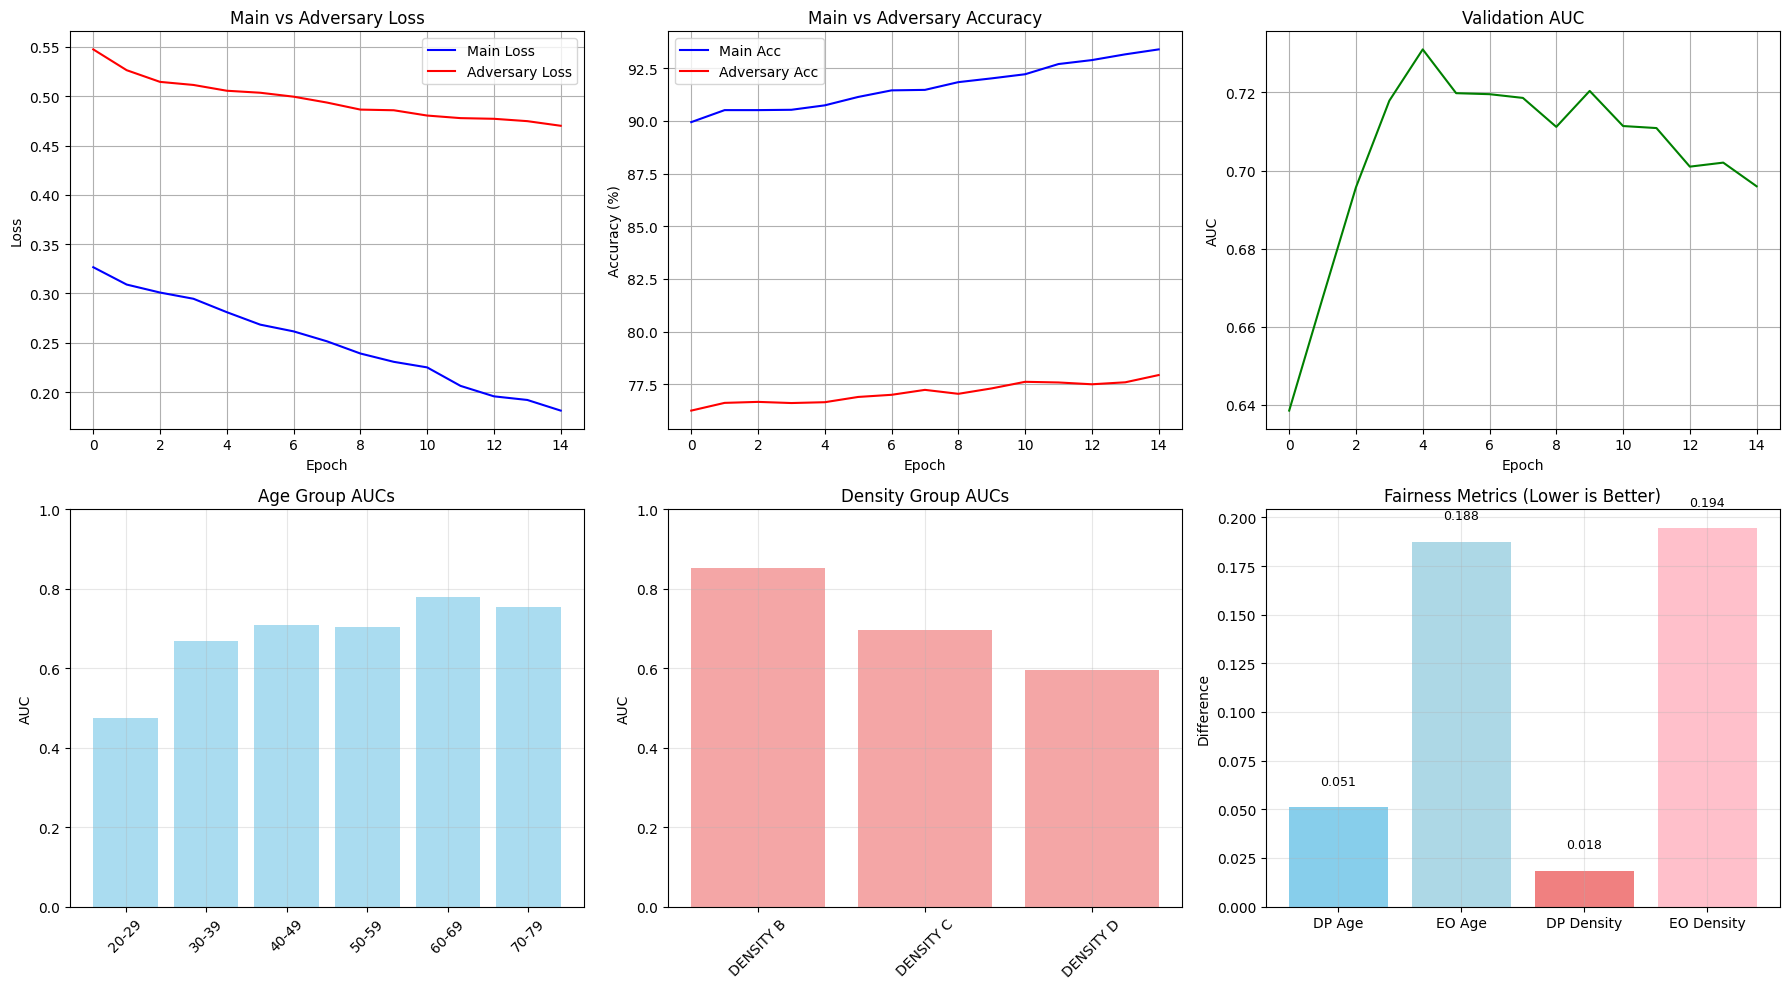

In [ ]:
#visualize the result

print("\n" + "="*50)
print("VISUALIZING ADVERSARIAL TRAINING RESULTS")
print("="*50)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Main and adversary loss
axes[0, 0].plot(train_history['main_loss'], label='Main Loss', color='blue')
axes[0, 0].plot(train_history['adv_loss'], label='Adversary Loss', color='red')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Main vs Adversary Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Main and adversary accuracy
axes[0, 1].plot(train_history['main_acc'], label='Main Acc', color='blue')
axes[0, 1].plot(train_history['adv_acc'], label='Adversary Acc', color='red')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Main vs Adversary Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Validation AUC
axes[0, 2].plot(train_history['val_auc'], color='green')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('AUC')
axes[0, 2].set_title('Validation AUC')
axes[0, 2].grid(True)

# Subgroup AUC comparison - Age
if age_results:
    sorted_ages = sort_age_groups(age_results.keys())
    age_names = [str(age) for age in sorted_ages]
    age_aucs = [age_results[age]['auc'] for age in sorted_ages if not np.isnan(age_results[age]['auc'])]

    axes[1, 0].bar(range(len(age_aucs)), age_aucs, color='skyblue', alpha=0.7)
    axes[1, 0].set_xticks(range(len(age_aucs)))
    axes[1, 0].set_xticklabels([str(a) for a in sorted_ages if not np.isnan(age_results[a]['auc'])], rotation=45)
    axes[1, 0].set_ylabel('AUC')
    axes[1, 0].set_title('Age Group AUCs')
    axes[1, 0].set_ylim([0, 1.0])
    axes[1, 0].grid(True, alpha=0.3)

# Subgroup AUC comparison - Density
if density_results:
    density_names = []
    density_aucs = []
    for density in density_order:
        if density in density_results and not np.isnan(density_results[density]['auc']):
            density_names.append(density)
            density_aucs.append(density_results[density]['auc'])

    axes[1, 1].bar(range(len(density_aucs)), density_aucs, color='lightcoral', alpha=0.7)
    axes[1, 1].set_xticks(range(len(density_aucs)))
    axes[1, 1].set_xticklabels(density_names, rotation=45)
    axes[1, 1].set_ylabel('AUC')
    axes[1, 1].set_title('Density Group AUCs')
    axes[1, 1].set_ylim([0, 1.0])
    axes[1, 1].grid(True, alpha=0.3)

# Fairness metrics comparison
fairness_metrics = ['DP Age', 'EO Age', 'DP Density', 'EO Density']
fairness_values = [dp_age_diff, eo_age_diff, dp_density_diff, eo_density_diff]

bars = axes[1, 2].bar(fairness_metrics, fairness_values,
                      color=['skyblue', 'lightblue', 'lightcoral', 'pink'])
axes[1, 2].set_ylabel('Difference')
axes[1, 2].set_title('Fairness Metrics (Lower is Better)')
axes[1, 2].grid(True, alpha=0.3)

# Add values on bars
for bar, value in zip(bars, fairness_values):
    height = bar.get_height()
    axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_DIR, 'adversarial_training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# complete result summary

print("\n" + "="*50)
print("adversarial debiasing result ")
print("="*50)

print(f"\nOverall performance:")
print(f"  Test AUC: {test_auc:.4f}")
print(f"  Test accuracy: {test_acc:.2f}%")
print(f"  Test loss: {test_loss:.4f}")

print(f"\nFairness improvements:")
print(f"  Age demographic parity: {dp_age_diff:.4f}")
print(f"  Age equal opportunity: {eo_age_diff:.4f}")
print(f"  Density demographic parity: {dp_density_diff:.4f}")
print(f"  Density equal opportunity: {eo_density_diff:.4f}")




adversarial debiasing result 

Overall performance:
  Test AUC: 0.7026
  Test accuracy: 91.03%
  Test loss: 0.2917

Fairness improvements:
  Age demographic parity: 0.0511
  Age equal opportunity: 0.1875
  Density demographic parity: 0.0184
  Density equal opportunity: 0.1944


In [ ]:
#save

print("\nSaving adversarial debiasing results...")

results = {
    'overall_performance': {
        'test_loss': float(test_loss),
        'test_accuracy': float(test_acc),
        'test_auc': float(test_auc)
    },
    'subgroup_performance': {
        'age_groups': {str(k): v for k, v in age_results.items()},
        'breast_density': {str(k): v for k, v in density_results.items()}
    },
    'fairness_metrics': {
        'demographic_parity': {
            'age_difference': float(dp_age_diff),
            'density_difference': float(dp_density_diff),
            'age_rates': {str(k): float(v) for k, v in dp_age_rates.items()},
            'density_rates': {str(k): float(v) for k, v in dp_density_rates.items()}
        },
        'equal_opportunity': {
            'age_difference': float(eo_age_diff),
            'density_difference': float(eo_density_diff),
            'age_tprs': {str(k): float(v) for k, v in eo_age_tprs.items()},
            'density_tprs': {str(k): float(v) for k, v in eo_density_tprs.items()}
        }
    },
    'training_history': train_history,
    'adversarial_effectiveness': {
        'best_lambda': float(checkpoint.get('lambda_val', 1.0)),
        'final_epoch': int(checkpoint.get('epoch', 0))
    },
    'dataset_statistics': {
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'class_distribution': {
            'class_0': int(sum(train_df['binary_label'] == 0)),
            'class_1': int(sum(train_df['binary_label'] == 1))
        },
        'sensitive_attribute_distribution': {
            'age_young': int(sum(train_df['age_attribute'] == 0)),
            'age_old': int(sum(train_df['age_attribute'] == 1)),
            'density_low': int(sum(train_df['density_attribute'] == 0)),
            'density_high': int(sum(train_df['density_attribute'] == 1))
        }
    }
}

with open(RESULTS_FILE, 'w') as f:
    json.dump(results, f, indent=2, default=str)

print(f"\nResults saved to: {RESULTS_FILE}")
print(f"Model checkpoint saved to: {ADVERSARIAL_CHECKPOINT}")




Saving adversarial debiasing results...

Results saved to: /content/drive/MyDrive/IT_artefact/Adversarial_checkpoints/adversarial_results.json
Model checkpoint saved to: /content/drive/MyDrive/IT_artefact/Adversarial_checkpoints/adversarial_model.pth


**Explainability tools**

visualize heatmap


GRAD-CAM visualization and analysis 

Generating Grad-CAM visualizations for selected samples...


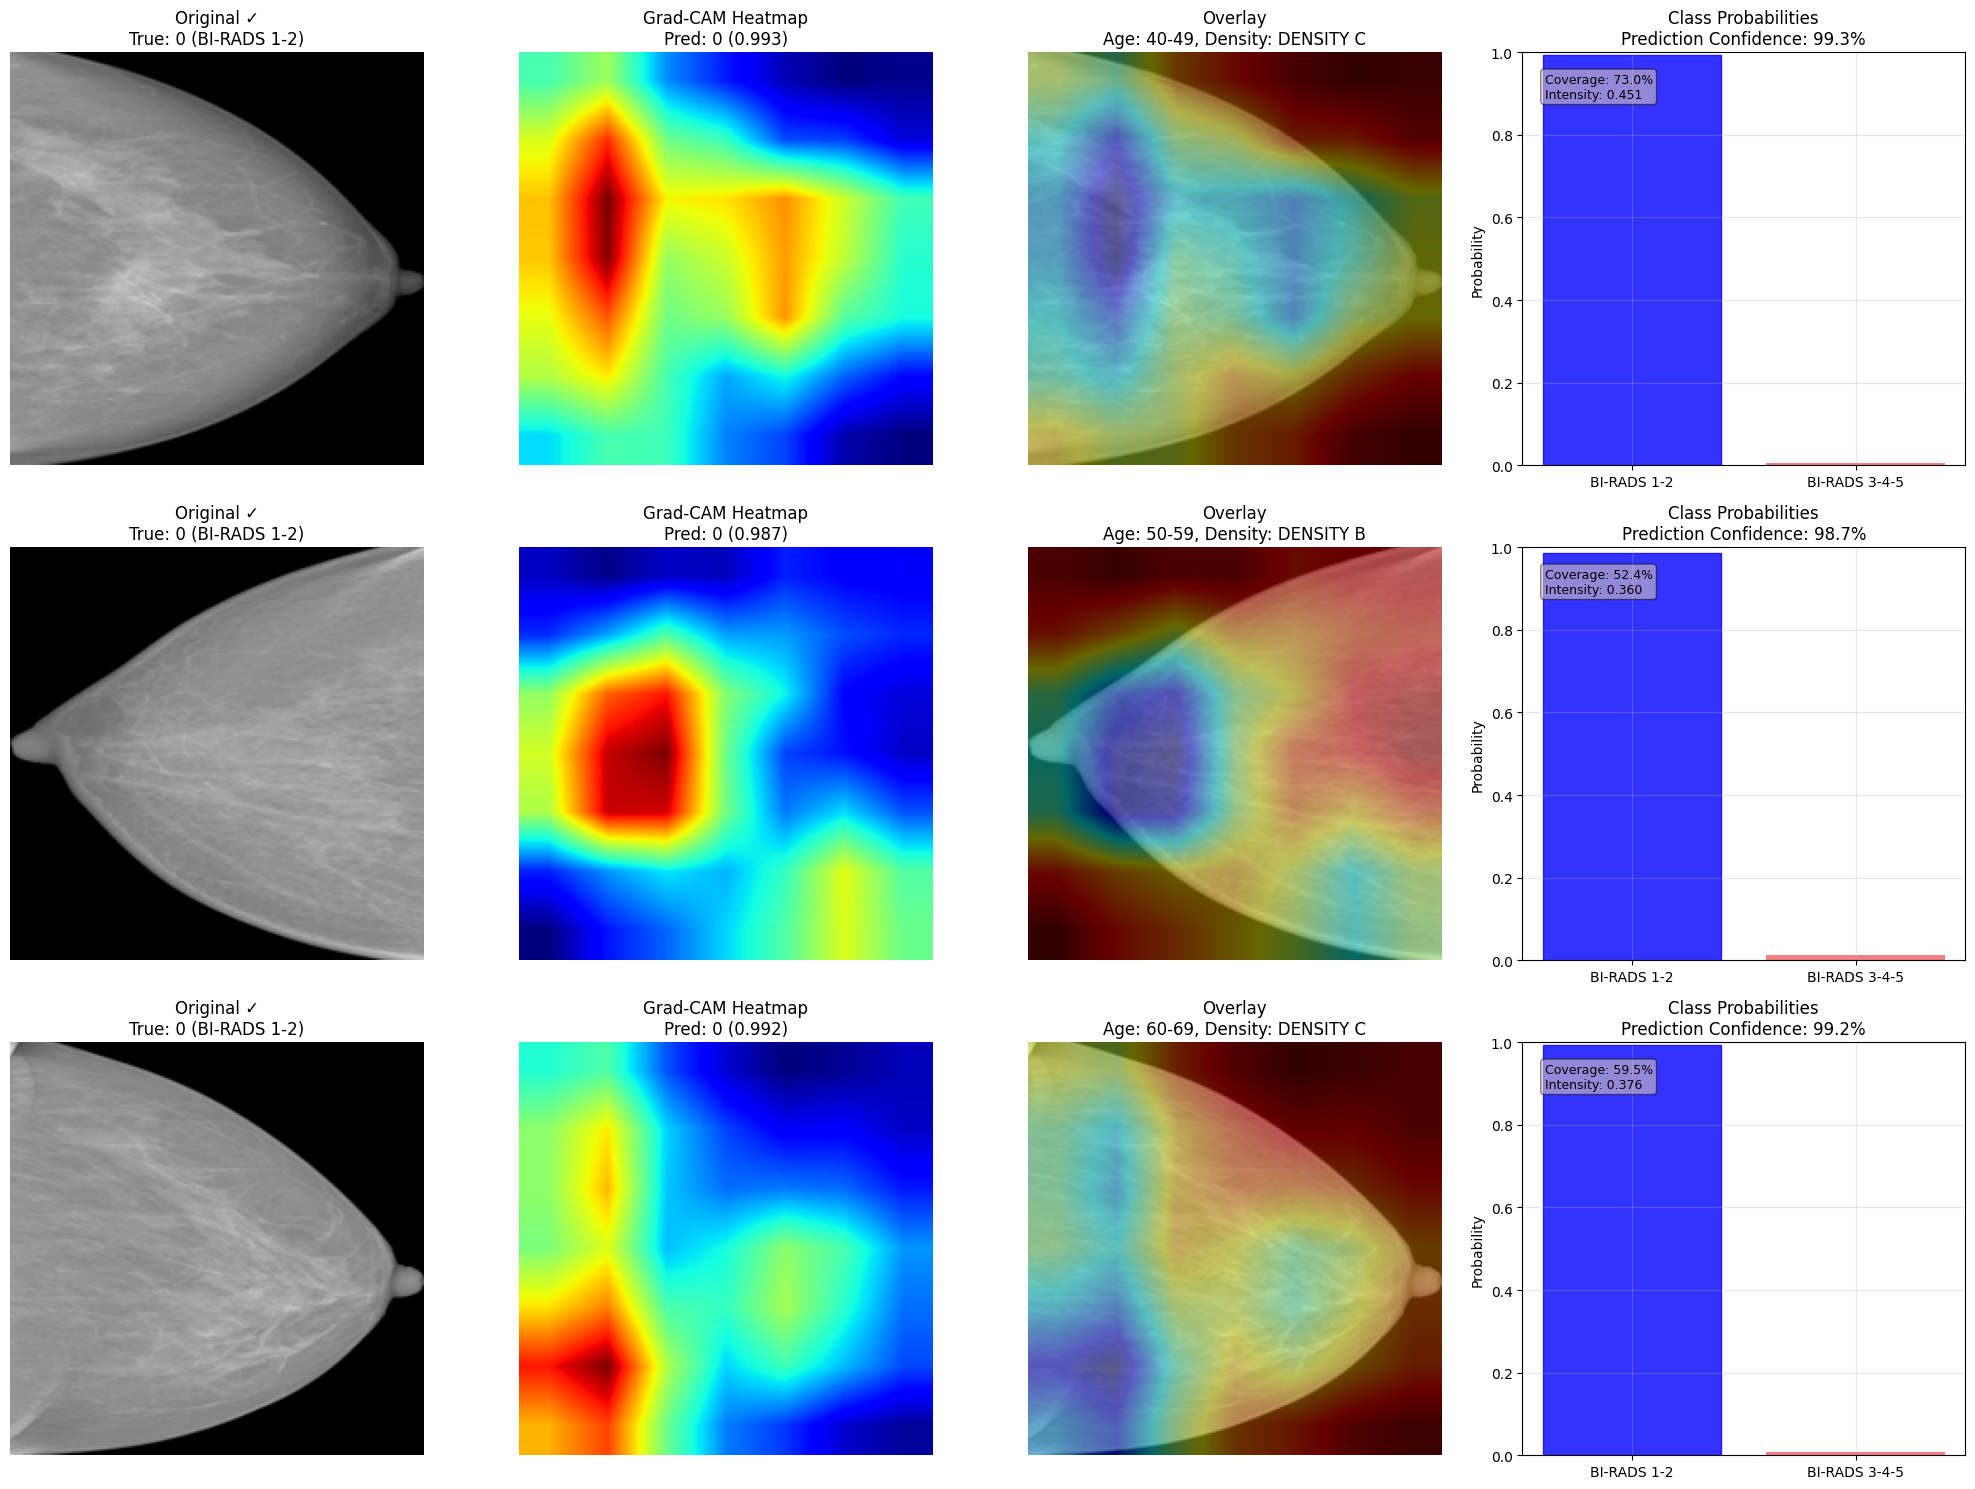

Grad-CAM visualizations saved to: /content/drive/MyDrive/IT_artefact/Adversarial_checkpoints/adversarial_gradcam_examples.png


In [ ]:

# GRAD-CAM Visualization and numerical analysis


print("\n" + "="*50)
print("GRAD-CAM visualization and analysis ")
print("="*50)

class GradCAMWrapper:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output.detach()

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()

        # Forward pass - get main outputs only
        main_output, _ = self.model(input_tensor, lambda_val=0.0)

        # If class_idx not specified, use predicted class
        if class_idx is None:
            class_idx = main_output.argmax(dim=1).item()

        # Backward pass for specified class
        one_hot = torch.zeros_like(main_output)
        one_hot[0, class_idx] = 1
        main_output.backward(gradient=one_hot)

        # Calculate weights
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)

        # Generate CAM
        cam = torch.sum(weights * self.activations, dim=1)
        cam = torch.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        # Resize to input size
        cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam, class_idx, main_output

# few samples
print("\nGenerating Grad-CAM visualizations for selected samples...")

# Get target layer (last convolutional layer in DenseNet)
target_layer = model.backbone.features[-1]

# Create Grad-CAM wrapper
gradcam = GradCAMWrapper(model, target_layer)

# Select 3 random samples
sample_indices = np.random.choice(len(test_df), min(3, len(test_df)), replace=False)

fig, axes = plt.subplots(len(sample_indices), 4, figsize=(20, 5*len(sample_indices)))

if len(sample_indices) == 1:
    axes = axes.reshape(1, -1)

for idx, (ax_row, sample_idx) in enumerate(zip(axes, sample_indices)):
    sample = test_df.iloc[sample_idx]

    # Load and prepare image
    img_path = sample['preprocessed_path']
    try:
        original_img = Image.open(img_path).convert('RGB')
    except:
        # If image can't be loaded, create a black image
        original_img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')

    input_tensor = val_transform(original_img).unsqueeze(0).to(DEVICE)

    # Get prediction
    with torch.no_grad():
        main_output, _ = model(input_tensor, lambda_val=0.0)
        probs = torch.softmax(main_output, dim=1)[0]
        pred_class = main_output.argmax(dim=1).item()
        pred_prob = probs[pred_class].item()
        true_label = sample['binary_label']

    # Generate Grad-CAM
    cam, _, _ = gradcam.generate(input_tensor, pred_class)

    # Prepare images for display
    display_img = np.array(original_img.resize((IMG_SIZE, IMG_SIZE)))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(display_img, 0.6, heatmap, 0.4, 0)

    # Original image
    ax_row[0].imshow(display_img)
    correct_icon = "✓" if pred_class == true_label else "✗"
    ax_row[0].set_title(f"Original {correct_icon}\nTrue: {true_label} ({'BI-RADS 3-4-5' if true_label == 1 else 'BI-RADS 1-2'})")
    ax_row[0].axis('off')

    # Heatmap
    ax_row[1].imshow(cam, cmap='jet')
    ax_row[1].set_title(f"Grad-CAM Heatmap\nPred: {pred_class} ({pred_prob:.3f})")
    ax_row[1].axis('off')

    # Overlay
    ax_row[2].imshow(overlay)
    ax_row[2].set_title(f"Overlay\nAge: {sample['Age Group']}, Density: {sample['breast_density']}")
    ax_row[2].axis('off')

    # Probability distribution
    bars = ax_row[3].bar(['BI-RADS 1-2', 'BI-RADS 3-4-5'], probs.cpu().numpy(),
                        color=['lightblue', 'lightcoral'])
    ax_row[3].set_ylim([0, 1])
    ax_row[3].set_title(f"Class Probabilities\nPrediction Confidence: {pred_prob:.1%}")
    ax_row[3].set_ylabel("Probability")
    ax_row[3].grid(True, alpha=0.3)

    # Highlight predicted class
    bars[pred_class].set_color('red' if pred_class == 1 else 'blue')
    bars[pred_class].set_alpha(0.8)

    # Add metrics text
    coverage = np.mean(cam > 0.3) * 100
    intensity = np.mean(cam)
    text_str = f"Coverage: {coverage:.1f}%\nIntensity: {intensity:.3f}"
    ax_row[3].text(0.05, 0.95, text_str, transform=ax_row[3].transAxes,
                  fontsize=9, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
gradcam_path = os.path.join(CHECKPOINT_DIR, 'adversarial_gradcam_examples.png')
plt.savefig(gradcam_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Grad-CAM visualizations saved to: {gradcam_path}")


complementary numerical analysis

In [ ]:
#Grad-CAM statistics

print("\n" + "="*50)
print("GRAD-CAM statistical analysis")
print("="*50)

def analyze_heatmap(cam):
    """Simple analysis of heatmap"""
    # Coverage percentage
    coverage = np.mean(cam > 0.3) * 100

    # Intensity stats
    avg_intensity = np.mean(cam)
    max_intensity = np.max(cam)

    # Find connected regions
    binary_mask = (cam > 0.3).astype(np.uint8)
    num_labels = cv2.connectedComponents(binary_mask, connectivity=8)[0] - 1

    return {
        'coverage': coverage,
        'avg_intensity': avg_intensity,
        'max_intensity': max_intensity,
        'num_regions': num_labels
    }

# Analyze multiple samples
print("\nAnalyzing Grad-CAM patterns for 50 random samples...")

num_samples = min(50, len(test_df))
sample_indices = np.random.choice(len(test_df), num_samples, replace=False)

all_analyses = []
correct_analyses = []
incorrect_analyses = []

for i, sample_idx in enumerate(sample_indices):
    if i % 10 == 0:
        print(f"  Processing sample {i+1}/{num_samples}...")

    sample = test_df.iloc[sample_idx]

    try:
        # Load and prepare image
        img_path = sample['preprocessed_path']
        original_img = Image.open(img_path).convert('RGB')
        input_tensor = val_transform(original_img).unsqueeze(0).to(DEVICE)

        # Get prediction
        with torch.no_grad():
            main_output, _ = model(input_tensor, lambda_val=0.0)
            pred_class = main_output.argmax(dim=1).item()

        # Generate and analyze Grad-CAM
        cam, _, _ = gradcam.generate(input_tensor, pred_class)
        analysis = analyze_heatmap(cam)

        # Add metadata
        analysis['is_correct'] = (pred_class == sample['binary_label'])
        analysis['age_group'] = sample['Age Group']
        analysis['density'] = sample['breast_density']
        analysis['pred_class'] = pred_class
        analysis['true_class'] = sample['binary_label']

        all_analyses.append(analysis)

        if analysis['is_correct']:
            correct_analyses.append(analysis)
        else:
            incorrect_analyses.append(analysis)
    except Exception as e:
        continue

# Print summary statistics
print(f"\nGrad-CAM Statistics Summary (n={len(all_analyses)}):")
print(f"  Correct predictions: {len(correct_analyses)} ({len(correct_analyses)/len(all_analyses):.1%})")
print(f"  Incorrect predictions: {len(incorrect_analyses)} ({len(incorrect_analyses)/len(all_analyses):.1%})")

if len(all_analyses) > 0:
    # Calculate statistics
    coverage_correct = np.mean([a['coverage'] for a in correct_analyses]) if correct_analyses else 0
    coverage_incorrect = np.mean([a['coverage'] for a in incorrect_analyses]) if incorrect_analyses else 0

    intensity_correct = np.mean([a['avg_intensity'] for a in correct_analyses]) if correct_analyses else 0
    intensity_incorrect = np.mean([a['avg_intensity'] for a in incorrect_analyses]) if incorrect_analyses else 0

    print(f"\nAttention Patterns:")
    print(f"  Coverage (area model looks at):")
    print(f"    Correct predictions: {coverage_correct:.1f}%")
    print(f"    Incorrect predictions: {coverage_incorrect:.1f}%")
    print(f"    Difference: {coverage_correct - coverage_incorrect:+.1f}%")

    print(f"\n  Intensity (confidence of attention):")
    print(f"    Correct predictions: {intensity_correct:.3f}")
    print(f"    Incorrect predictions: {intensity_incorrect:.3f}")
    print(f"    Difference: {intensity_correct - intensity_incorrect:+.3f}")

    # Interpretation
    print(f"\nInterpretation:")
    if coverage_correct > coverage_incorrect + 5:
        print("  - Model looks at broader areas for correct predictions")
    elif coverage_correct < coverage_incorrect - 5:
        print("  - Model focuses more narrowly for correct predictions")
    else:
        print("  - Similar attention area for correct/incorrect predictions")

    if intensity_correct > intensity_incorrect + 0.1:
        print("  - More confident attention for correct predictions")
    elif intensity_correct < intensity_incorrect - 0.1:
        print("  - Less confident but correct attention patterns")
    else:
        print("  - Similar attention intensity")

# Add Grad-CAM analysis to results
results['gradcam_analysis'] = {
    'total_samples_analyzed': len(all_analyses),
    'correct_predictions': len(correct_analyses),
    'incorrect_predictions': len(incorrect_analyses),
    'coverage_correct': float(coverage_correct) if correct_analyses else None,
    'coverage_incorrect': float(coverage_incorrect) if incorrect_analyses else None,
    'intensity_correct': float(intensity_correct) if correct_analyses else None,
    'intensity_incorrect': float(intensity_incorrect) if incorrect_analyses else None
}

print("\n" + "="*50)
print("GRAD-CAM ANALYSIS COMPLETE")
print("="*50)


GRAD-CAM statistical analysis

Analyzing Grad-CAM patterns for 50 random samples...
  Processing sample 1/50...
  Processing sample 11/50...
  Processing sample 21/50...
  Processing sample 31/50...
  Processing sample 41/50...

Grad-CAM Statistics Summary (n=50):
  Correct predictions: 43 (86.0%)
  Incorrect predictions: 7 (14.0%)

Attention Patterns:
  Coverage (area model looks at):
    Correct predictions: 65.1%
    Incorrect predictions: 69.9%
    Difference: -4.8%

  Intensity (confidence of attention):
    Correct predictions: 0.415
    Incorrect predictions: 0.428
    Difference: -0.013

Interpretation:
  - Similar attention area for correct/incorrect predictions
  - Similar attention intensity

GRAD-CAM ANALYSIS COMPLETE
